# **Libraries Import**

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance
from collections import Counter

# For DL Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from PIL import Image, ImageEnhance
import os
import numpy as np
from tqdm import tqdm
import random

# Import necessary libraries
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from skimage import feature
import cv2  # Import OpenCV for SURF feature extraction
from skimage import color
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image, ImageEnhance
import numpy as np
import torchmetrics
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from torchvision.models import vgg16

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

# **Connecting Drive & Splitting Data**

In [2]:
train_dataset = ['G:/MISC files/Research/Brain_Tumor/classification/Training', 'G:/MISC files/Research/Brain_Tumor/mri/Training']
test_dataset = ['G:/MISC files/Research/Brain_Tumor/classification/Testing', 'G:/MISC files/Research/Brain_Tumor/mri/Testing']

# **Processing Training Data**

In [3]:
train_paths = []
train_labels = []

for train_dir in train_dataset:
    for label in os.listdir(train_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(train_dir, label)):
            train_paths.append(os.path.join(train_dir, label, image))
            train_labels.append(real_label)

train_paths, train_labels = shuffle(train_paths, train_labels)

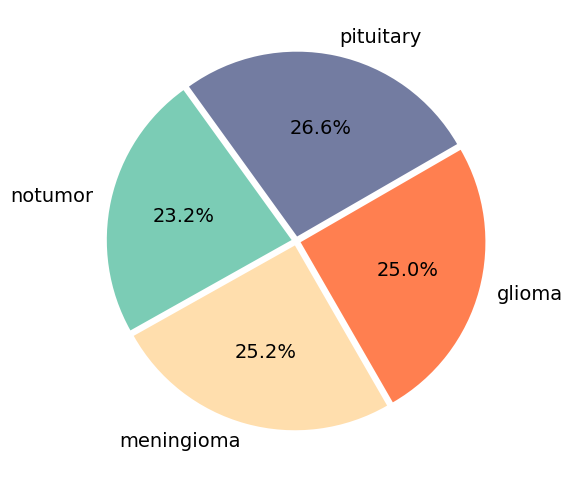

In [4]:
plt.figure(figsize=(14,6))
colors = ['#737CA1', '#7BCCB5', '#FFDEAD', '#FF7F50']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x == 'pituitary']),
         len([x for x in train_labels if x == 'notumor']),
         len([x for x in train_labels if x == 'meningioma']),
         len([x for x in train_labels if x == 'glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

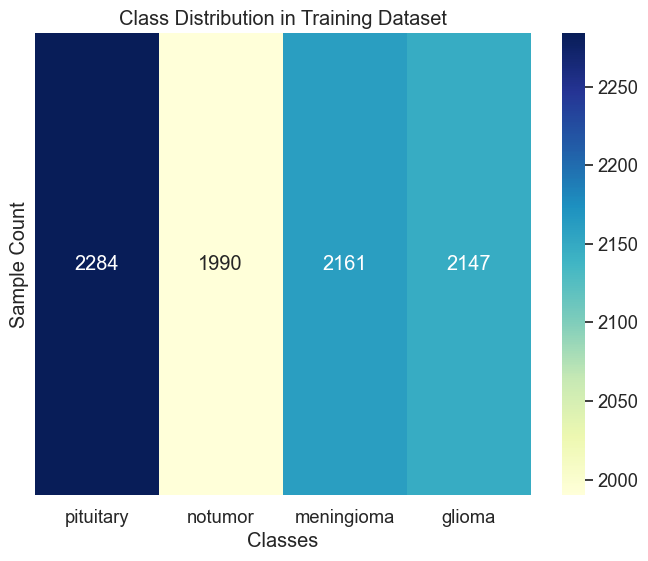

In [5]:
class_counts = dict(Counter(train_labels))

class_names = ['pituitary', 'notumor', 'meningioma', 'glioma']
class_distribution = [class_counts.get(name, 0) for name in class_names]

data_for_heatmap = [class_distribution] 

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(data_for_heatmap, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=False)
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Sample Count')
plt.show()

# **Processing Testing Data**

In [6]:
test_paths = []
test_labels = []

for test_dir in test_dataset:
    for label in os.listdir(test_dir):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(test_dir, label)):
            test_paths.append(os.path.join(test_dir, label, image))
            test_labels.append(real_label)

test_paths, test_labels = shuffle(test_paths, test_labels)

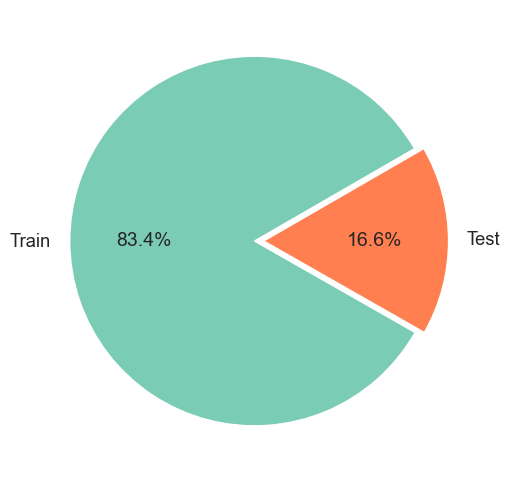

In [7]:
plt.figure(figsize=(14,6))
colors = ['#7BCCB5', '#FF7F50']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# **Image Loading, Augmentation & Visualization**

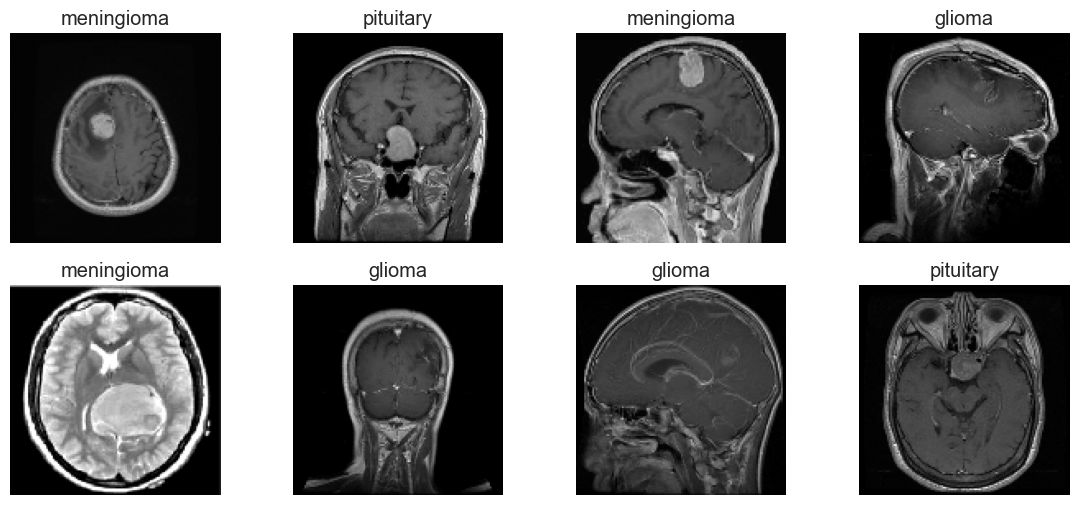

In [8]:
IMAGE_SIZE = 128

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[0:9])
labels = train_labels[0:9]
fig = plt.figure(figsize=(14, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# **Encoding & Decoding The Label of Images**

In [9]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# **Building a CNN using VGG16 As Base**

In [27]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_7 (Dropout)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 81

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [30]:
batch_size = 50
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
171/171 [==============================] - 228s 1s/step - loss: 0.4635 - sparse_categorical_accuracy: 0.8207
Epoch 2/10
171/171 [==============================] - 258s 2s/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9232
Epoch 3/10
171/171 [==============================] - 223s 1s/step - loss: 0.1078 - sparse_categorical_accuracy: 0.9602
Epoch 4/10
171/171 [==============================] - 217s 1s/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9696
Epoch 5/10
171/171 [==============================] - 213s 1s/step - loss: 0.0617 - sparse_categorical_accuracy: 0.9771
Epoch 6/10
171/171 [==============================] - 213s 1s/step - loss: 0.0439 - sparse_categorical_accuracy: 0.9838
Epoch 7/10
171/171 [==============================] - 212s 1s/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9910
Epoch 8/10
171/171 [==============================] - 212s 1s/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9900
Epoch 9/10
171/171 [====================

In [31]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 637ms/step


  2%|▏         | 1/53 [00:00<00:39,  1.33it/s]

1/1 [==============================] - 1s 562ms/step


  4%|▍         | 2/53 [00:01<00:35,  1.44it/s]

1/1 [==============================] - 1s 564ms/step


  6%|▌         | 3/53 [00:02<00:33,  1.48it/s]

1/1 [==============================] - 1s 558ms/step


  8%|▊         | 4/53 [00:02<00:32,  1.50it/s]

1/1 [==============================] - 1s 567ms/step


  9%|▉         | 5/53 [00:03<00:31,  1.51it/s]

1/1 [==============================] - 1s 569ms/step


 11%|█▏        | 6/53 [00:04<00:31,  1.51it/s]

1/1 [==============================] - 1s 571ms/step


 13%|█▎        | 7/53 [00:04<00:30,  1.49it/s]

1/1 [==============================] - 1s 564ms/step


 15%|█▌        | 8/53 [00:05<00:29,  1.50it/s]

1/1 [==============================] - 1s 563ms/step


 17%|█▋        | 9/53 [00:06<00:29,  1.51it/s]

1/1 [==============================] - 1s 560ms/step


 19%|█▉        | 10/53 [00:06<00:28,  1.51it/s]

1/1 [==============================] - 1s 565ms/step


 21%|██        | 11/53 [00:07<00:27,  1.51it/s]

1/1 [==============================] - 1s 566ms/step


 23%|██▎       | 12/53 [00:08<00:27,  1.51it/s]

1/1 [==============================] - 1s 561ms/step


 25%|██▍       | 13/53 [00:08<00:26,  1.52it/s]

1/1 [==============================] - 1s 563ms/step


 26%|██▋       | 14/53 [00:09<00:25,  1.52it/s]

1/1 [==============================] - 1s 569ms/step


 28%|██▊       | 15/53 [00:09<00:25,  1.52it/s]

1/1 [==============================] - 1s 564ms/step


 30%|███       | 16/53 [00:10<00:24,  1.52it/s]

1/1 [==============================] - 1s 573ms/step


 32%|███▏      | 17/53 [00:11<00:23,  1.50it/s]

1/1 [==============================] - 1s 564ms/step


 34%|███▍      | 18/53 [00:11<00:23,  1.51it/s]

1/1 [==============================] - 1s 559ms/step


 36%|███▌      | 19/53 [00:12<00:22,  1.52it/s]

1/1 [==============================] - 1s 557ms/step


 38%|███▊      | 20/53 [00:13<00:21,  1.53it/s]

1/1 [==============================] - 1s 558ms/step


 40%|███▉      | 21/53 [00:13<00:20,  1.53it/s]

1/1 [==============================] - 1s 564ms/step


 42%|████▏     | 22/53 [00:14<00:20,  1.53it/s]

1/1 [==============================] - 1s 561ms/step


 43%|████▎     | 23/53 [00:15<00:19,  1.54it/s]

1/1 [==============================] - 1s 557ms/step


 45%|████▌     | 24/53 [00:15<00:18,  1.54it/s]

1/1 [==============================] - 1s 575ms/step


 47%|████▋     | 25/53 [00:16<00:18,  1.53it/s]

1/1 [==============================] - 1s 572ms/step


 49%|████▉     | 26/53 [00:17<00:17,  1.52it/s]

1/1 [==============================] - 1s 563ms/step


 51%|█████     | 27/53 [00:17<00:17,  1.51it/s]

1/1 [==============================] - 1s 558ms/step


 53%|█████▎    | 28/53 [00:18<00:16,  1.52it/s]

1/1 [==============================] - 1s 559ms/step


 55%|█████▍    | 29/53 [00:19<00:15,  1.52it/s]

1/1 [==============================] - 1s 559ms/step


 57%|█████▋    | 30/53 [00:19<00:15,  1.53it/s]

1/1 [==============================] - 1s 566ms/step


 58%|█████▊    | 31/53 [00:20<00:14,  1.52it/s]

1/1 [==============================] - 1s 568ms/step


 60%|██████    | 32/53 [00:21<00:13,  1.52it/s]

1/1 [==============================] - 1s 562ms/step


 62%|██████▏   | 33/53 [00:21<00:13,  1.52it/s]

1/1 [==============================] - 1s 572ms/step


 64%|██████▍   | 34/53 [00:22<00:12,  1.52it/s]

1/1 [==============================] - 1s 563ms/step


 66%|██████▌   | 35/53 [00:23<00:11,  1.52it/s]

1/1 [==============================] - 1s 588ms/step


 68%|██████▊   | 36/53 [00:23<00:11,  1.49it/s]

1/1 [==============================] - 1s 572ms/step


 70%|██████▉   | 37/53 [00:24<00:10,  1.49it/s]

1/1 [==============================] - 1s 566ms/step


 72%|███████▏  | 38/53 [00:25<00:09,  1.50it/s]

1/1 [==============================] - 1s 562ms/step


 74%|███████▎  | 39/53 [00:25<00:09,  1.51it/s]

1/1 [==============================] - 1s 565ms/step


 75%|███████▌  | 40/53 [00:26<00:08,  1.52it/s]

1/1 [==============================] - 1s 578ms/step


 77%|███████▋  | 41/53 [00:27<00:07,  1.51it/s]

1/1 [==============================] - 1s 568ms/step


 79%|███████▉  | 42/53 [00:27<00:07,  1.52it/s]

1/1 [==============================] - 1s 572ms/step


 81%|████████  | 43/53 [00:28<00:06,  1.51it/s]

1/1 [==============================] - 1s 568ms/step


 83%|████████▎ | 44/53 [00:29<00:05,  1.51it/s]

1/1 [==============================] - 1s 557ms/step


 85%|████████▍ | 45/53 [00:29<00:05,  1.51it/s]

1/1 [==============================] - 1s 567ms/step


 87%|████████▋ | 46/53 [00:30<00:04,  1.51it/s]

1/1 [==============================] - 1s 563ms/step


 89%|████████▊ | 47/53 [00:31<00:03,  1.51it/s]

1/1 [==============================] - 1s 562ms/step


 91%|█████████ | 48/53 [00:31<00:03,  1.52it/s]

1/1 [==============================] - 1s 564ms/step


 92%|█████████▏| 49/53 [00:32<00:02,  1.52it/s]

1/1 [==============================] - 1s 568ms/step


 94%|█████████▍| 50/53 [00:33<00:01,  1.52it/s]

1/1 [==============================] - 1s 563ms/step


 96%|█████████▌| 51/53 [00:33<00:01,  1.52it/s]

1/1 [==============================] - 1s 563ms/step


 98%|█████████▊| 52/53 [00:34<00:00,  1.52it/s]

1/1 [==============================] - 1s 561ms/step


100%|██████████| 53/53 [00:35<00:00,  1.51it/s]

1/1 [==============================] - 0s 261ms/step


54it [00:35,  1.53it/s]                        


In [44]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.92      0.81      0.86       400
  meningioma       0.91      0.92      0.92       421
     notumor       0.94      1.00      0.97       510
   pituitary       0.94      0.98      0.96       374

    accuracy                           0.93      1705
   macro avg       0.93      0.93      0.93      1705
weighted avg       0.93      0.93      0.93      1705



Resnet50

In [22]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of ResNet50 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [23]:
# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_5 (Dropout)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 27782660 (105.98 MB)
Trainable params: 5

In [24]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [25]:
# Define batch size and number of epochs
batch_size = 50
epochs = 10
steps = int(len(train_paths) / batch_size)

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
171/171 [==============================] - 117s 668ms/step - loss: 0.8035 - sparse_categorical_accuracy: 0.6669
Epoch 2/10
171/171 [==============================] - 118s 692ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.7416
Epoch 3/10
171/171 [==============================] - 111s 650ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.7761
Epoch 4/10
171/171 [==============================] - 117s 685ms/step - loss: 0.4897 - sparse_categorical_accuracy: 0.7986
Epoch 5/10
171/171 [==============================] - 93s 547ms/step - loss: 0.4501 - sparse_categorical_accuracy: 0.8154
Epoch 6/10
171/171 [==============================] - 102s 596ms/step - loss: 0.4263 - sparse_categorical_accuracy: 0.8256
Epoch 7/10
171/171 [==============================] - 101s 588ms/step - loss: 0.4040 - sparse_categorical_accuracy: 0.8322
Epoch 8/10
171/171 [==============================] - 98s 572ms/step - loss: 0.3817 - sparse_categorical_accuracy: 0.8411
Epoch 9/10
171/171

In [33]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)


  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 568ms/step


  2%|▏         | 1/53 [00:00<00:36,  1.42it/s]

1/1 [==============================] - 1s 559ms/step


  4%|▍         | 2/53 [00:01<00:34,  1.49it/s]

1/1 [==============================] - 1s 558ms/step


  6%|▌         | 3/53 [00:01<00:32,  1.52it/s]

1/1 [==============================] - 1s 564ms/step


  8%|▊         | 4/53 [00:02<00:32,  1.52it/s]

1/1 [==============================] - 1s 559ms/step


  9%|▉         | 5/53 [00:03<00:31,  1.53it/s]

1/1 [==============================] - 1s 558ms/step


 11%|█▏        | 6/53 [00:03<00:30,  1.54it/s]

1/1 [==============================] - 1s 556ms/step


 13%|█▎        | 7/53 [00:04<00:29,  1.54it/s]

1/1 [==============================] - 1s 553ms/step


 15%|█▌        | 8/53 [00:05<00:29,  1.55it/s]

1/1 [==============================] - 1s 561ms/step


 17%|█▋        | 9/53 [00:05<00:28,  1.54it/s]

1/1 [==============================] - 1s 557ms/step


 19%|█▉        | 10/53 [00:06<00:27,  1.54it/s]

1/1 [==============================] - 1s 554ms/step


 21%|██        | 11/53 [00:07<00:27,  1.54it/s]

1/1 [==============================] - 1s 565ms/step


 23%|██▎       | 12/53 [00:07<00:26,  1.54it/s]

1/1 [==============================] - 1s 556ms/step


 25%|██▍       | 13/53 [00:08<00:25,  1.54it/s]

1/1 [==============================] - 1s 557ms/step


 26%|██▋       | 14/53 [00:09<00:25,  1.54it/s]

1/1 [==============================] - 1s 563ms/step


 28%|██▊       | 15/53 [00:09<00:24,  1.54it/s]

1/1 [==============================] - 1s 551ms/step


 30%|███       | 16/53 [00:10<00:23,  1.55it/s]

1/1 [==============================] - 1s 559ms/step


 32%|███▏      | 17/53 [00:11<00:23,  1.55it/s]

1/1 [==============================] - 1s 555ms/step


 34%|███▍      | 18/53 [00:11<00:22,  1.55it/s]

1/1 [==============================] - 1s 550ms/step


 36%|███▌      | 19/53 [00:12<00:21,  1.56it/s]

1/1 [==============================] - 1s 561ms/step


 38%|███▊      | 20/53 [00:12<00:21,  1.56it/s]

1/1 [==============================] - 1s 549ms/step


 40%|███▉      | 21/53 [00:13<00:20,  1.56it/s]

1/1 [==============================] - 1s 558ms/step


 42%|████▏     | 22/53 [00:14<00:19,  1.56it/s]

1/1 [==============================] - 1s 551ms/step


 43%|████▎     | 23/53 [00:14<00:19,  1.57it/s]

1/1 [==============================] - 1s 544ms/step


 45%|████▌     | 24/53 [00:15<00:18,  1.57it/s]

1/1 [==============================] - 1s 544ms/step


 47%|████▋     | 25/53 [00:16<00:17,  1.57it/s]

1/1 [==============================] - 1s 548ms/step


 49%|████▉     | 26/53 [00:16<00:17,  1.57it/s]

1/1 [==============================] - 1s 545ms/step


 51%|█████     | 27/53 [00:17<00:16,  1.58it/s]

1/1 [==============================] - 1s 553ms/step


 53%|█████▎    | 28/53 [00:18<00:15,  1.57it/s]

1/1 [==============================] - 1s 551ms/step


 55%|█████▍    | 29/53 [00:18<00:15,  1.57it/s]

1/1 [==============================] - 1s 550ms/step


 57%|█████▋    | 30/53 [00:19<00:14,  1.56it/s]

1/1 [==============================] - 1s 551ms/step


 58%|█████▊    | 31/53 [00:20<00:14,  1.55it/s]

1/1 [==============================] - 1s 551ms/step


 60%|██████    | 32/53 [00:20<00:13,  1.55it/s]

1/1 [==============================] - 1s 544ms/step


 62%|██████▏   | 33/53 [00:21<00:12,  1.56it/s]

1/1 [==============================] - 1s 548ms/step


 64%|██████▍   | 34/53 [00:21<00:12,  1.57it/s]

1/1 [==============================] - 1s 550ms/step


 66%|██████▌   | 35/53 [00:22<00:11,  1.56it/s]

1/1 [==============================] - 1s 557ms/step


 68%|██████▊   | 36/53 [00:23<00:10,  1.55it/s]

1/1 [==============================] - 1s 559ms/step


 70%|██████▉   | 37/53 [00:23<00:10,  1.55it/s]

1/1 [==============================] - 1s 554ms/step


 72%|███████▏  | 38/53 [00:24<00:09,  1.55it/s]

1/1 [==============================] - 1s 555ms/step


 74%|███████▎  | 39/53 [00:25<00:09,  1.55it/s]

1/1 [==============================] - 1s 554ms/step


 75%|███████▌  | 40/53 [00:25<00:08,  1.56it/s]

1/1 [==============================] - 1s 556ms/step


 77%|███████▋  | 41/53 [00:26<00:07,  1.55it/s]

1/1 [==============================] - 1s 562ms/step


 79%|███████▉  | 42/53 [00:27<00:07,  1.55it/s]

1/1 [==============================] - 1s 554ms/step


 81%|████████  | 43/53 [00:27<00:06,  1.55it/s]

1/1 [==============================] - 1s 547ms/step


 83%|████████▎ | 44/53 [00:28<00:05,  1.55it/s]

1/1 [==============================] - 1s 558ms/step


 85%|████████▍ | 45/53 [00:29<00:05,  1.55it/s]

1/1 [==============================] - 1s 550ms/step


 87%|████████▋ | 46/53 [00:29<00:04,  1.56it/s]

1/1 [==============================] - 1s 550ms/step


 89%|████████▊ | 47/53 [00:30<00:03,  1.56it/s]

1/1 [==============================] - 1s 550ms/step


 91%|█████████ | 48/53 [00:30<00:03,  1.56it/s]

1/1 [==============================] - 1s 554ms/step


 92%|█████████▏| 49/53 [00:31<00:02,  1.56it/s]

1/1 [==============================] - 1s 551ms/step


 94%|█████████▍| 50/53 [00:32<00:01,  1.56it/s]

1/1 [==============================] - 1s 560ms/step


 96%|█████████▌| 51/53 [00:32<00:01,  1.55it/s]

1/1 [==============================] - 1s 553ms/step


 98%|█████████▊| 52/53 [00:33<00:00,  1.55it/s]

1/1 [==============================] - 1s 545ms/step


100%|██████████| 53/53 [00:34<00:00,  1.55it/s]

1/1 [==============================] - 0s 173ms/step


54it [00:34,  1.57it/s]                        


In [32]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.98      0.78      0.87       400
  meningioma       0.92      0.93      0.93       421
     notumor       0.85      1.00      0.92       510
   pituitary       0.98      0.94      0.96       374

    accuracy                           0.92      1705
   macro avg       0.93      0.91      0.92      1705
weighted avg       0.93      0.92      0.92      1705



InceptionV3

In [36]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of InceptionV3 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(unique_labels), activation='softmax'))

87910968/87910968 [==============================] - 93s 1us/step


In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_9 (Dropout)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 23901220 (91.18 MB)
Trainable params: 20

In [38]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [42]:
# Define batch size and number of epochs
batch_size = 50
epochs = 15

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/15
53/53 [==============================] - 15s 276ms/step - loss: 0.4758 - sparse_categorical_accuracy: 0.8143
Epoch 2/15
53/53 [==============================] - 18s 349ms/step - loss: 0.4905 - sparse_categorical_accuracy: 0.8068
Epoch 3/15
53/53 [==============================] - 20s 368ms/step - loss: 0.4424 - sparse_categorical_accuracy: 0.8370
Epoch 4/15
53/53 [==============================] - 19s 362ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.8309
Epoch 5/15
53/53 [==============================] - 21s 395ms/step - loss: 0.4081 - sparse_categorical_accuracy: 0.8404
Epoch 6/15
53/53 [==============================] - 18s 339ms/step - loss: 0.4155 - sparse_categorical_accuracy: 0.8392
Epoch 7/15
53/53 [==============================] - 17s 325ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8522
Epoch 8/15
53/53 [==============================] - 18s 342ms/step - loss: 0.3687 - sparse_categorical_accuracy: 0.8562
Epoch 9/15
53/53 [======================

In [43]:
# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/53 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▏         | 1/53 [00:01<01:07,  1.30s/it]

1/1 [==============================] - 0s 164ms/step


  4%|▍         | 2/53 [00:01<00:35,  1.44it/s]

1/1 [==============================] - 0s 163ms/step


  6%|▌         | 3/53 [00:01<00:25,  2.00it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 4/53 [00:02<00:19,  2.46it/s]

1/1 [==============================] - 0s 168ms/step


  9%|▉         | 5/53 [00:02<00:17,  2.82it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█▏        | 6/53 [00:02<00:15,  3.01it/s]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 7/53 [00:02<00:14,  3.23it/s]

1/1 [==============================] - 0s 155ms/step


 15%|█▌        | 8/53 [00:03<00:13,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 17%|█▋        | 9/53 [00:03<00:12,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 19%|█▉        | 10/53 [00:03<00:12,  3.53it/s]

1/1 [==============================] - 0s 186ms/step


 21%|██        | 11/53 [00:04<00:11,  3.50it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██▎       | 12/53 [00:04<00:11,  3.55it/s]

1/1 [==============================] - 0s 168ms/step


 25%|██▍       | 13/53 [00:04<00:11,  3.55it/s]

1/1 [==============================] - 0s 170ms/step


 26%|██▋       | 14/53 [00:04<00:10,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 28%|██▊       | 15/53 [00:05<00:10,  3.57it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 16/53 [00:05<00:10,  3.69it/s]

1/1 [==============================] - 0s 166ms/step


 32%|███▏      | 17/53 [00:05<00:09,  3.72it/s]

1/1 [==============================] - 0s 170ms/step


 34%|███▍      | 18/53 [00:05<00:09,  3.64it/s]

1/1 [==============================] - 0s 180ms/step


 36%|███▌      | 19/53 [00:06<00:09,  3.51it/s]

1/1 [==============================] - 0s 178ms/step


 38%|███▊      | 20/53 [00:06<00:09,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 40%|███▉      | 21/53 [00:06<00:08,  3.59it/s]

1/1 [==============================] - 0s 168ms/step


 42%|████▏     | 22/53 [00:07<00:08,  3.67it/s]

1/1 [==============================] - 0s 161ms/step


 43%|████▎     | 23/53 [00:07<00:08,  3.65it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▌     | 24/53 [00:07<00:07,  3.73it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 25/53 [00:07<00:07,  3.75it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▉     | 26/53 [00:08<00:07,  3.81it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 27/53 [00:08<00:06,  3.87it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████▎    | 28/53 [00:08<00:06,  3.88it/s]

1/1 [==============================] - 0s 162ms/step


 55%|█████▍    | 29/53 [00:08<00:06,  3.84it/s]

1/1 [==============================] - 0s 160ms/step


 57%|█████▋    | 30/53 [00:09<00:05,  3.84it/s]

1/1 [==============================] - 0s 161ms/step


 58%|█████▊    | 31/53 [00:09<00:05,  3.83it/s]

1/1 [==============================] - 0s 168ms/step


 60%|██████    | 32/53 [00:09<00:05,  3.68it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 33/53 [00:09<00:05,  3.73it/s]

1/1 [==============================] - 0s 163ms/step


 64%|██████▍   | 34/53 [00:10<00:04,  3.80it/s]

1/1 [==============================] - 0s 160ms/step


 66%|██████▌   | 35/53 [00:10<00:04,  3.76it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 36/53 [00:10<00:04,  3.79it/s]

1/1 [==============================] - 0s 167ms/step


 70%|██████▉   | 37/53 [00:10<00:04,  3.74it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████▏  | 38/53 [00:11<00:03,  3.76it/s]

1/1 [==============================] - 0s 165ms/step


 74%|███████▎  | 39/53 [00:11<00:03,  3.69it/s]

1/1 [==============================] - 0s 158ms/step


 75%|███████▌  | 40/53 [00:11<00:03,  3.76it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 41/53 [00:12<00:03,  3.79it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 42/53 [00:12<00:02,  3.81it/s]

1/1 [==============================] - 0s 161ms/step


 81%|████████  | 43/53 [00:12<00:02,  3.77it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████▎ | 44/53 [00:12<00:02,  3.79it/s]

1/1 [==============================] - 0s 160ms/step


 85%|████████▍ | 45/53 [00:13<00:02,  3.73it/s]

1/1 [==============================] - 0s 170ms/step


 87%|████████▋ | 46/53 [00:13<00:01,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 89%|████████▊ | 47/53 [00:13<00:01,  3.57it/s]

1/1 [==============================] - 0s 158ms/step


 91%|█████████ | 48/53 [00:13<00:01,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


 92%|█████████▏| 49/53 [00:14<00:01,  3.66it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████▍| 50/53 [00:14<00:00,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


 96%|█████████▌| 51/53 [00:14<00:00,  3.80it/s]

1/1 [==============================] - 0s 160ms/step


 98%|█████████▊| 52/53 [00:15<00:00,  3.77it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 53/53 [00:15<00:00,  3.74it/s]

1/1 [==============================] - 1s 986ms/step


54it [00:16,  3.31it/s]                        


In [44]:
# Print classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.91      0.72      0.81       400
  meningioma       0.79      0.83      0.81       421
     notumor       0.89      0.98      0.93       510
   pituitary       0.87      0.89      0.88       374

    accuracy                           0.86      1705
   macro avg       0.87      0.86      0.86      1705
weighted avg       0.87      0.86      0.86      1705



Mobilenetv3

In [ ]:
from keras.applications import MobileNetV3Small
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Load pre-trained MobileNetV3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last block of MobileNetV3 to trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build the model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))  # Change dropout rate
model.add(Dense(256, activation='relu'))  # Change number of neurons
model.add(Dropout(0.3))  # Change dropout rate
model.add(Dense(len(unique_labels), activation='softmax'))

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Define batch size and number of epochs
batch_size = 32  # Change batch size
epochs = 15  # Change number of epochs

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

# Make predictions on test data
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

# Print classification report
print(classification_report(y_true, y_pred))


# **Applying ML Models & Fetching the Result**

In [14]:
def evaluate_model(predictions, true_labels, model_name, runtime):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"{model_name} Accuracy: {accuracy*100:.4f}%")
    print(f"{model_name} Precision: {precision*100:.4f}%")
    print(f"{model_name} Recall: {recall*100:.4f}%")
    print(f"{model_name} F1 Score: {f1*100:.4f}%")
    print(f"{model_name} Training and Classification Time: {runtime:.6f} seconds")

In [17]:
from sklearn.metrics import classification_report

def evaluate_model_detailed(predictions, true_labels, model_name, runtime=None):
    # Print classification report
    report = classification_report(true_labels, predictions, target_names=['glioma', 'meningioma', 'notumor', 'pituitary'])
    print(f"{model_name} Classification Report:\n{report}")

    # Print accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy * 100:.4f}%")
    print(f"Precision: {precision * 100:.4f}%")
    print(f"Recall: {recall * 100:.4f}%")
    print(f"F1 Score: {f1 * 100:.4f}%")

    # Print runtime if available
    if runtime:
        print(f"{model_name} Training and Classification Time: {runtime:.6f} seconds")

**Support Vector Machine**

In [15]:
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    features, _ = hog(gray_image, visualize=True)
    return features


train_images = open_images(train_paths)
hog_features_train = [extract_hog_features(image) for image in train_images]

le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_labels)

hog_features_train_tensor = torch.tensor(hog_features_train, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)

train_dataset = TensorDataset(hog_features_train_tensor, train_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_images = open_images(test_paths)
hog_features_test = [extract_hog_features(image) for image in test_images]
test_labels_encoded = le.transform(test_labels)

svm_model_hog = svm.SVC()
start_time = time.time()
svm_model_hog.fit(hog_features_train, train_labels)
svm_predictions_hog = svm_model_hog.predict(hog_features_test)
svm_runtime_hog = time.time() - start_time

test_labels_decoded = le.inverse_transform(test_labels_encoded)

evaluate_model(svm_predictions_hog, test_labels_decoded, "SVM with HOG", svm_runtime_hog)



C:\Users\fdipt\AppData\Local\Temp\ipykernel_22952\598351751.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  hog_features_train_tensor = torch.tensor(hog_features_train, dtype=torch.float32)


SVM with HOG Accuracy: 91.3783%
SVM with HOG Precision: 91.5853%
SVM with HOG Recall: 91.3783%
SVM with HOG F1 Score: 91.0903%
SVM with HOG Training and Classification Time: 362.688210 seconds


In [18]:
evaluate_model_detailed(svm_predictions_hog, test_labels_decoded, "SVM with HOG", svm_runtime_hog)

SVM with HOG Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.73      0.83       400
  meningioma       0.87      0.92      0.90       421
     notumor       0.91      1.00      0.95       510
   pituitary       0.95      0.98      0.96       374

    accuracy                           0.91      1705
   macro avg       0.92      0.91      0.91      1705
weighted avg       0.92      0.91      0.91      1705


SVM with HOG Metrics:
Accuracy: 91.3783%
Precision: 91.5853%
Recall: 91.3783%
F1 Score: 91.0903%
SVM with HOG Training and Classification Time: 362.688210 seconds


**K-Nearest Neighbors**

In [24]:
# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
knn_model.fit(hog_features_train, train_labels)
knn_predictions = knn_model.predict(hog_features_test)
knn_runtime = time.time() - start_time

evaluate_model(knn_predictions, test_labels_decoded, "KNN", knn_runtime)

KNN Accuracy: 85.3959%
KNN Precision: 86.0491%
KNN Recall: 85.3959%
KNN F1 Score: 85.0752%
KNN Training and Classification Time: 3.842667 seconds


In [25]:
evaluate_model_detailed(knn_predictions, test_labels_decoded, "KNN", knn_runtime)

KNN Classification Report:
              precision    recall  f1-score   support

      glioma       0.92      0.75      0.82       400
  meningioma       0.88      0.73      0.80       421
     notumor       0.82      0.96      0.89       510
   pituitary       0.82      0.96      0.89       374

    accuracy                           0.85      1705
   macro avg       0.86      0.85      0.85      1705
weighted avg       0.86      0.85      0.85      1705


KNN Metrics:
Accuracy: 85.3959%
Precision: 86.0491%
Recall: 85.3959%
F1 Score: 85.0752%
KNN Training and Classification Time: 3.842667 seconds


**Random Forrest**

In [26]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
start_time = time.time()
rf_model.fit(hog_features_train, train_labels)
rf_predictions = rf_model.predict(hog_features_test)
rf_runtime = time.time() - start_time

evaluate_model(rf_predictions, test_labels_decoded, "Random Forest", rf_runtime)

Random Forest Accuracy: 86.8622%
Random Forest Precision: 87.1695%
Random Forest Recall: 86.8622%
Random Forest F1 Score: 86.2765%
Random Forest Training and Classification Time: 227.604929 seconds


In [27]:
evaluate_model_detailed(rf_predictions, test_labels_decoded, "Random Forest", rf_runtime)

Random Forest Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.64      0.75       400
  meningioma       0.84      0.87      0.85       421
     notumor       0.88      0.99      0.93       510
   pituitary       0.86      0.95      0.90       374

    accuracy                           0.87      1705
   macro avg       0.87      0.86      0.86      1705
weighted avg       0.87      0.87      0.86      1705


Random Forest Metrics:
Accuracy: 86.8622%
Precision: 87.1695%
Recall: 86.8622%
F1 Score: 86.2765%
Random Forest Training and Classification Time: 227.604929 seconds
